In [21]:
## Library import
import torch
import os
import glob
import pandas as pd
import re
import numpy as np
import isodate
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import time
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
from scipy.special import softmax
import pandas as pd
import torch
from tqdm import tqdm


In [5]:
## Data loading
DATA_DIR=r"C:\Users\lixia\Downloads\dataset"

#comment data
commentData = glob.glob(os.path.join(DATA_DIR, "comments[1-5].csv"))
commentData.sort()
df_comments = pd.concat([pd.read_csv(f) for f in commentData], ignore_index=True)
print("Merged shape Comment Data:", df_comments.shape)
print(df_comments.columns.tolist())

#video data
df_video = pd.read_csv(os.path.join(DATA_DIR, "videos.csv"))
print("Merged shape Video Data:", df_video.shape)
print(df_video.columns.tolist())





Merged shape Comment Data: (4725012, 10)
['kind', 'commentId', 'channelId', 'videoId', 'authorId', 'textOriginal', 'parentCommentId', 'likeCount', 'publishedAt', 'updatedAt']
Merged shape Video Data: (92759, 15)
['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration', 'viewCount', 'likeCount', 'favouriteCount', 'commentCount', 'topicCategories']


In [3]:

# -----------------------------
# Custom Dataset
# -----------------------------
class CommentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# -----------------------------
# Load model + tokenizer on GPU
# -----------------------------
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")
if device == 0:
    model = model.to("cuda")

# -----------------------------
# Prepare Data
# -----------------------------
texts = df_comments['textOriginal'].astype(str).tolist()
dataset = CommentDataset(texts, tokenizer)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# -----------------------------
# Inference with ETA logging
# -----------------------------
all_preds = []
all_scores = []

model.eval()
start_time = time.time()
total_batches = len(loader)

with torch.no_grad():
    for i, batch in enumerate(tqdm(loader, desc="Processing", unit="batch")):
        input_ids = batch["input_ids"].to("cuda" if device == 0 else "cpu")
        attention_mask = batch["attention_mask"].to("cuda" if device == 0 else "cpu")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())

        # --- ETA log every 500 batches ---
        if (i + 1) % 500 == 0:
            elapsed = time.time() - start_time
            avg_time_per_batch = elapsed / (i + 1)
            remaining_batches = total_batches - (i + 1)
            eta_seconds = remaining_batches * avg_time_per_batch
            hrs = int(eta_seconds // 3600)
            mins = int((eta_seconds % 3600) // 60)
            print(f"\n[ETA] Remaining time: ~{hrs}h {mins}m\n")
# -----------------------------
# Attach to DataFrame
# -----------------------------
df_comments["predicted_label"] = all_preds
df_comments["score"] = all_scores

# -----------------------------
# Save 50 toxic & 50 non-toxic
# -----------------------------
toxic_sample = df_comments[df_comments['predicted_label'] == 1].head(50)
non_toxic_sample = df_comments[df_comments['predicted_label'] == 0].head(50)

toxic_sample.to_csv("toxic_sample.csv", index=False)
non_toxic_sample.to_csv("non_toxic_sample.csv", index=False)

print(f"Total comments: {len(df_comments)}")
print(f"Toxic comments: {len(toxic_sample)} saved to toxic_sample.csv")
print(f"Non-toxic comments: {len(non_toxic_sample)} saved to non_toxic_sample.csv")


Using device: GPU


Processing:   0%|          | 156/147657 [00:28<7:24:29,  5.53batch/s]


KeyboardInterrupt: 

In [12]:
import pandas as pd
import re
import emoji

# -----------------------------
# Step 0: Define the updated spam rule
# -----------------------------
def is_spam_text(text):
    if pd.isna(text) or len(str(text).strip()) == 0:
        return True  # empty comment

    text = str(text)
    text_lower = text.lower()

    # Rule 1: Contains links
    if "http" in text_lower or "www." in text_lower or ".com" in text_lower:
        return True

    # Rule 2: Very short comments only
    if len(text) < 3:
        return True

    # Rule 3: Majority symbols/emojis
    total_chars = len(text)
    if total_chars > 0:
        symbol_count = len(re.findall(r'[^\w\s]', text))
        emoji_count = len(emoji.emoji_list(text))
        if (symbol_count + emoji_count) / total_chars > 0.5:
            return True

    # Rule 4: Majority uppercase letters
    letters_only = re.sub(r'[^A-Za-z]', '', text)
    if len(letters_only) > 0:
        upper_count = sum(1 for c in letters_only if c.isupper())
        if upper_count / len(letters_only) > 0.5:
            return True

    return False

# -----------------------------
# Step 1: Flag repeated comments across videos
# -----------------------------
# Count how many times each author-text pair appears
dup_counts = df_comments.groupby(['authorId','textOriginal'], observed=False).size().reset_index(name='count')

# Get set of repeated comments
repeated_set = set(
    tuple(x) for x in dup_counts[dup_counts['count'] > 1][['authorId','textOriginal']].values
)

# -----------------------------
# Step 2: Apply spam rules (vectorized)
# -----------------------------
# Flag spam comments
df_comments['spam_rule'] = df_comments['textOriginal'].apply(is_spam_text)

# Flag repeated comments
df_comments['repeated_across_videos'] = df_comments.apply(
    lambda row: (row['authorId'], row['textOriginal']) in repeated_set, axis=1
)

# -----------------------------
# Step 3: Combine all spam flags into one unified column
# -----------------------------
df_comments['is_spam'] = df_comments['spam_rule'] | df_comments['repeated_across_videos']

# -----------------------------
# Step 4: Save clean and spam comments separately
# -----------------------------
clean_comments = df_comments[~df_comments['is_spam']].copy()
spam_comments = df_comments[df_comments['is_spam']].copy()

# -----------------------------
# Step 5: Summary
# -----------------------------
print(f"Total comments: {len(df_comments)}")
print(f"Spam comments: {len(spam_comments)} saved to spam_comments.csv")
print(f"Clean comments: {len(clean_comments)} saved to clean_comments.csv")

# -----------------------------
# Optional: Display examples
# -----------------------------
print("\n=== Example Spam Comments ===")
print(spam_comments[['authorId','textOriginal']].head(10).to_string(index=False))

print("\n=== Example Clean Comments ===")
print(clean_comments[['authorId','textOriginal']].head(10).to_string(index=False))


Total comments: 4725012
Spam comments: 865374 saved to spam_comments.csv
Clean comments: 3859638 saved to clean_comments.csv

=== Example Spam Comments ===
 authorId                                        textOriginal
  2032536 PLEASE LESBIAN FLAG I BEG YOU \n\nYou would rock it
  2775194                                          ❤❤❤❤❤❤❤❤❤❤
  3158722                                                   ❤
   785546                                                Love
  2502640                            RadheKrishna🙏🙏🌸🌸❤❤😍😍🧿🧿🥰🥰
  3610950                              💞💞💞💞💞💞💞💞💞🙏🙏🙏🙏🙏🙏🙏🙏👍👍👍👍👍
  3415783                                ❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️
  2575009                                          Love u❤️❤️
   894013                                    You’re welcome 😊
  1198778                                        Thank you! 😊

=== Example Clean Comments ===
 authorId                                           textOriginal
  3043229       Apply mashed potato juice and mixed it with curd


In [13]:
clean_comments.to_csv("clean_comments.csv", index=False)
spam_comments.to_csv("spam_comments.csv", index=False)

In [16]:
# Filter top relative content based on soe with comments and without
# soe with = (likes + comments + shares +saves)/views

# Step 1: Convert ISO8601 duration → seconds (vectorized via list comprehension)
# Step 1a: Handle NaN / missing durations
def parse_duration_safe(x):
    if pd.isna(x):
        return 0  # or some default, e.g., 0 seconds
    try:
        return isodate.parse_duration(x).total_seconds()
    except:
        return 0  # fallback if parsing fails

df_video["duration_seconds"] = np.array([parse_duration_safe(x) for x in df_video["contentDuration"]])


# Step 2: Assign duration buckets (vectorized using pd.cut)
bins = [0, 60, 600, 1800, np.inf]  # seconds
labels = ["Short", "Medium", "Long", "Extended"]
df_video["duration_bucket"] = pd.cut(df_video["duration_seconds"], bins=bins, labels=labels, right=True)

# Step 3: Compute Adjusted Views
df_video["duration_safe"] = df_video["duration_seconds"].replace(0, 1)  # avoid divide by zero
df_video["AdjViews"] = df_video["viewCount"].clip(lower=10) / np.log1p(df_video["duration_safe"] + 1)

# Step 4: Compute weighted engagement (generic scale: comment>favourite>likes)
weights = np.array([1, 2, 5])  # likes, favourites, comments
df_video["weighted_engagement"] = df_video["likeCount"] * weights[0] + df_video["favouriteCount"] * weights[1] + df_video["commentCount"] * weights[2]

# Step 5: Compute SoE
df_video["SoE"] = df_video["weighted_engagement"] / df_video["AdjViews"]

# Optional: keep only necessary columns for analysis
df_result = df_video[["videoId", "duration_bucket", "duration_seconds", "viewCount", "AdjViews",
                "likeCount", "favouriteCount", "commentCount", "weighted_engagement", "SoE"]]

# Check results
print(df_video.columns.tolist())




['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration', 'viewCount', 'likeCount', 'favouriteCount', 'commentCount', 'topicCategories', 'duration_seconds', 'duration_bucket', 'duration_safe', 'AdjViews', 'weighted_engagement', 'SoE']


In [31]:
# Iterate over each duration bucket and save as separate CSV
for bucket in df_video["duration_bucket"].unique():
    if pd.isna(bucket):
        continue  # skip NaN buckets
    df_bucket = df_video[df_video["duration_bucket"] == bucket].copy()
    
    # File name includes bucket name
    file_name = os.path.join(DATA_DIR, f"videos_{bucket}.csv")
    df_bucket.to_csv(file_name, index=False)
    
    print(f"Saved {len(df_bucket)} videos to {file_name}")

Saved 81214 videos to C:\Users\lixia\Downloads\dataset\videos_Short.csv
Saved 8031 videos to C:\Users\lixia\Downloads\dataset\videos_Medium.csv
Saved 2077 videos to C:\Users\lixia\Downloads\dataset\videos_Long.csv
Saved 170 videos to C:\Users\lixia\Downloads\dataset\videos_Extended.csv


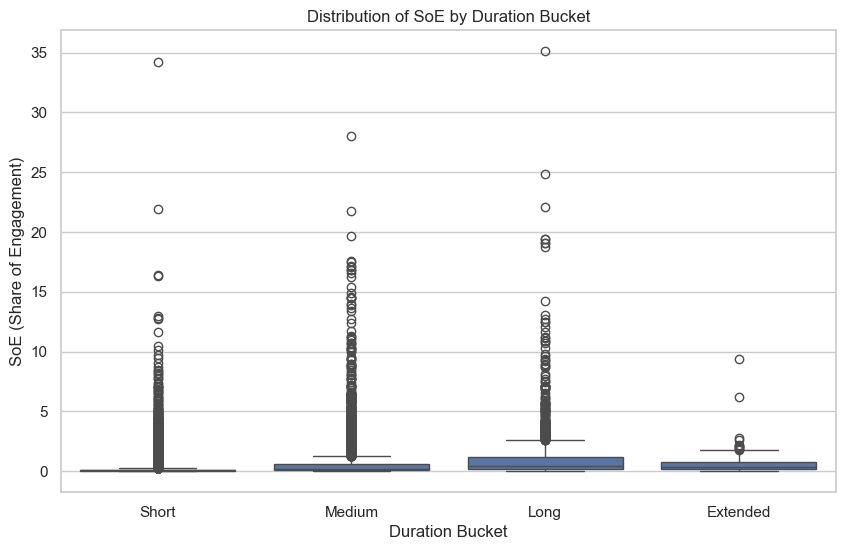

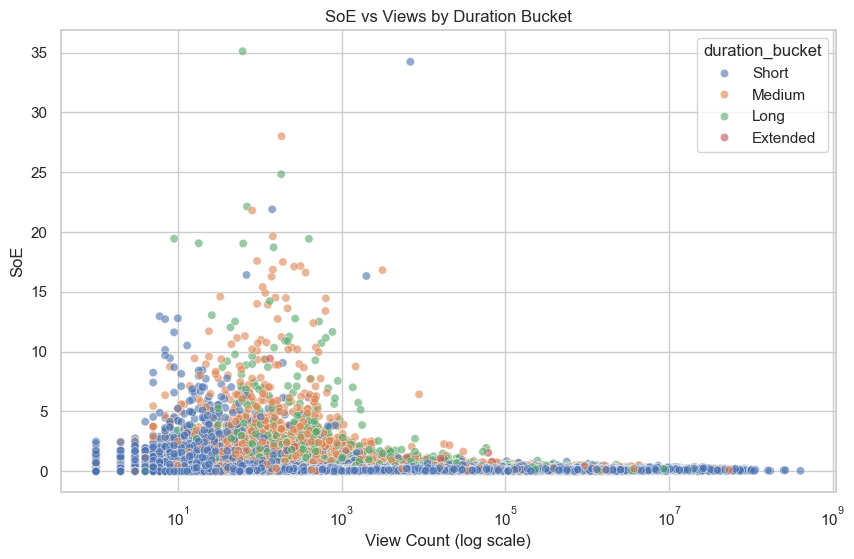

In [17]:
# Ensure seaborn style
sns.set(style="whitegrid")

# Example: df_video has columns: duration_bucket, SoE
plt.figure(figsize=(10,6))

# Boxplot: SoE distribution per duration bucket
sns.boxplot(x="duration_bucket", y="SoE", data=df_video, order=["Short", "Medium", "Long", "Extended"])
plt.title("Distribution of SoE by Duration Bucket")
plt.xlabel("Duration Bucket")
plt.ylabel("SoE (Share of Engagement)")
plt.show()

# Optional: scatter plot with views
plt.figure(figsize=(10,6))
sns.scatterplot(x="viewCount", y="SoE", hue="duration_bucket", data=df_video, alpha=0.6)
plt.xscale("log")  # optional, to handle large range of views
plt.title("SoE vs Views by Duration Bucket")
plt.xlabel("View Count (log scale)")
plt.ylabel("SoE")
plt.show()

In [20]:
cutoffs = (
    df_video.groupby("duration_bucket")["SoE"]
    .quantile(0.90)
    .reset_index()
    .rename(columns={"SoE": "SoE_cutoff"})
)

df_video_merged = df_video.merge(cutoffs, on="duration_bucket", how="left")
df_top_videos = df_video_merged[df_video_merged["SoE"] >= df_video_merged["SoE_cutoff"]].copy()
df_top_comments = clean_comments[clean_comments["videoId"].isin(df_top_videos["videoId"])].copy()

summary = (
    df_top_videos.groupby("duration_bucket")
    .agg(
        total_videos=("videoId", "count"),
        avg_SoE=("SoE", "mean")
    )
    .reset_index()
)

print("Top videos per bucket:")
print(summary)

print(f"\nTotal comments kept: {len(df_top_comments)}")

# Debug check: ensure no inf
print("\nCheck for infinite SoE values:", np.isinf(df_video["SoE"]).sum())

C:\Users\lixia\AppData\Local\Temp\ipykernel_34432\1150863726.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_video.groupby("duration_bucket")["SoE"]


Top videos per bucket:
  duration_bucket  total_videos   avg_SoE
0           Short          7598  0.708813
1          Medium           758  3.643066
2            Long           197  5.507731
3        Extended            17  2.612820

Total comments kept: 287695

Check for infinite SoE values: 0


C:\Users\lixia\AppData\Local\Temp\ipykernel_34432\1150863726.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top_videos.groupby("duration_bucket")


In [43]:

# -----------------------------
# Custom Dataset
# -----------------------------
class CommentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# -----------------------------
# Load model + tokenizer on GPU
# -----------------------------
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")
if device == 0:
    model = model.to("cuda")

# -----------------------------
# Prepare Data
# -----------------------------
texts = df_top_comments['textOriginal'].astype(str).tolist()
dataset = CommentDataset(texts, tokenizer)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# -----------------------------
# Inference with ETA logging
# -----------------------------
all_preds = []
all_scores = []

model.eval()
start_time = time.time()
total_batches = len(loader)

with torch.no_grad():
    for i, batch in enumerate(tqdm(loader, desc="Processing", unit="batch")):
        input_ids = batch["input_ids"].to("cuda" if device == 0 else "cpu")
        attention_mask = batch["attention_mask"].to("cuda" if device == 0 else "cpu")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())

        # --- ETA log every 500 batches ---
        if (i + 1) % 500 == 0:
            elapsed = time.time() - start_time
            avg_time_per_batch = elapsed / (i + 1)
            remaining_batches = total_batches - (i + 1)
            eta_seconds = remaining_batches * avg_time_per_batch
            hrs = int(eta_seconds // 3600)
            mins = int((eta_seconds % 3600) // 60)
            print(f"\n[ETA] Remaining time: ~{hrs}h {mins}m\n")
# -----------------------------
# Attach to DataFrame
# -----------------------------
df_top_comments["predicted_label"] = all_preds
df_top_comments["score"] = all_scores

# -----------------------------
# Save 50 toxic & 50 non-toxic
# -----------------------------
toxic_sample = df_top_comments[df_top_comments['predicted_label'] == 1].head(50)
non_toxic_sample = df_top_comments[df_top_comments['predicted_label'] == 0].head(50)

toxic_sample.to_csv("toxic_sample.csv", index=False)
non_toxic_sample.to_csv("non_toxic_sample.csv", index=False)

print(f"Total comments: {len(df_comments)}")
print(f"Toxic comments: {len(toxic_sample)} saved to toxic_sample.csv")
print(f"Non-toxic comments: {len(non_toxic_sample)} saved to non_toxic_sample.csv")


Using device: GPU


Processing:   1%|          | 501/64021 [01:30<3:20:22,  5.28batch/s]


[ETA] Remaining time: ~3h 11m



Processing:   2%|▏         | 1000/64021 [03:05<3:22:05,  5.20batch/s]


[ETA] Remaining time: ~3h 14m



Processing:   2%|▏         | 1500/64021 [04:43<3:24:58,  5.08batch/s]


[ETA] Remaining time: ~3h 16m



Processing:   3%|▎         | 2000/64021 [06:21<3:27:29,  4.98batch/s]


[ETA] Remaining time: ~3h 17m



Processing:   4%|▍         | 2501/64021 [08:01<3:27:31,  4.94batch/s]


[ETA] Remaining time: ~3h 17m



Processing:   5%|▍         | 3001/64021 [09:41<3:24:21,  4.98batch/s]


[ETA] Remaining time: ~3h 17m



Processing:   5%|▌         | 3501/64021 [11:22<3:23:23,  4.96batch/s]


[ETA] Remaining time: ~3h 16m



Processing:   6%|▌         | 4000/64021 [13:03<3:22:30,  4.94batch/s]


[ETA] Remaining time: ~3h 15m



Processing:   7%|▋         | 4500/64021 [14:43<3:18:34,  5.00batch/s]


[ETA] Remaining time: ~3h 14m



Processing:   8%|▊         | 5001/64021 [16:24<3:15:08,  5.04batch/s]


[ETA] Remaining time: ~3h 13m



Processing:   9%|▊         | 5500/64021 [18:05<3:17:47,  4.93batch/s]


[ETA] Remaining time: ~3h 12m



Processing:   9%|▉         | 6000/64021 [19:46<3:14:31,  4.97batch/s]


[ETA] Remaining time: ~3h 11m



Processing:  10%|█         | 6501/64021 [21:27<3:13:22,  4.96batch/s]


[ETA] Remaining time: ~3h 9m



Processing:  11%|█         | 7001/64021 [23:08<3:11:45,  4.96batch/s]


[ETA] Remaining time: ~3h 8m



Processing:  12%|█▏        | 7501/64021 [24:49<3:10:05,  4.96batch/s]


[ETA] Remaining time: ~3h 7m



Processing:  12%|█▏        | 8001/64021 [26:30<3:09:25,  4.93batch/s]


[ETA] Remaining time: ~3h 5m



Processing:  13%|█▎        | 8501/64021 [28:11<3:05:31,  4.99batch/s]


[ETA] Remaining time: ~3h 4m



Processing:  14%|█▍        | 9000/64021 [29:51<3:03:24,  5.00batch/s]


[ETA] Remaining time: ~3h 2m



Processing:  15%|█▍        | 9500/64021 [31:31<3:01:41,  5.00batch/s]


[ETA] Remaining time: ~3h 0m



Processing:  16%|█▌        | 10000/64021 [33:13<3:03:20,  4.91batch/s]


[ETA] Remaining time: ~2h 59m



Processing:  16%|█▋        | 10500/64021 [34:55<3:04:53,  4.82batch/s]


[ETA] Remaining time: ~2h 58m



Processing:  17%|█▋        | 11000/64021 [36:40<3:03:58,  4.80batch/s]


[ETA] Remaining time: ~2h 56m



Processing:  18%|█▊        | 11500/64021 [38:24<3:03:23,  4.77batch/s]


[ETA] Remaining time: ~2h 55m



Processing:  19%|█▊        | 12000/64021 [40:09<3:03:31,  4.72batch/s]


[ETA] Remaining time: ~2h 54m



Processing:  20%|█▉        | 12500/64021 [41:53<2:56:28,  4.87batch/s]


[ETA] Remaining time: ~2h 52m



Processing:  20%|██        | 13000/64021 [43:37<3:00:42,  4.71batch/s]


[ETA] Remaining time: ~2h 51m



Processing:  21%|██        | 13501/64021 [45:21<2:58:07,  4.73batch/s]


[ETA] Remaining time: ~2h 49m



Processing:  22%|██▏       | 14000/64021 [47:05<2:52:15,  4.84batch/s]


[ETA] Remaining time: ~2h 48m



Processing:  23%|██▎       | 14501/64021 [48:49<2:49:24,  4.87batch/s]


[ETA] Remaining time: ~2h 46m



Processing:  23%|██▎       | 15000/64021 [50:32<2:48:12,  4.86batch/s]


[ETA] Remaining time: ~2h 45m



Processing:  24%|██▍       | 15500/64021 [52:16<2:45:20,  4.89batch/s]


[ETA] Remaining time: ~2h 43m



Processing:  25%|██▍       | 16000/64021 [53:59<2:45:45,  4.83batch/s]


[ETA] Remaining time: ~2h 42m



Processing:  26%|██▌       | 16500/64021 [55:43<2:48:57,  4.69batch/s]


[ETA] Remaining time: ~2h 40m



Processing:  27%|██▋       | 17001/64021 [57:27<2:44:25,  4.77batch/s]


[ETA] Remaining time: ~2h 38m



Processing:  27%|██▋       | 17500/64021 [59:10<2:37:58,  4.91batch/s]


[ETA] Remaining time: ~2h 37m



Processing:  28%|██▊       | 18001/64021 [1:00:54<2:36:08,  4.91batch/s]


[ETA] Remaining time: ~2h 35m



Processing:  29%|██▉       | 18500/64021 [1:02:37<2:34:57,  4.90batch/s]


[ETA] Remaining time: ~2h 34m



Processing:  30%|██▉       | 19000/64021 [1:04:19<2:32:28,  4.92batch/s]


[ETA] Remaining time: ~2h 32m



Processing:  30%|███       | 19500/64021 [1:06:01<2:38:47,  4.67batch/s]


[ETA] Remaining time: ~2h 30m



Processing:  31%|███       | 20001/64021 [1:07:43<2:29:36,  4.90batch/s]


[ETA] Remaining time: ~2h 29m



Processing:  32%|███▏      | 20500/64021 [1:09:25<2:29:13,  4.86batch/s]


[ETA] Remaining time: ~2h 27m



Processing:  33%|███▎      | 21000/64021 [1:11:08<2:26:11,  4.90batch/s]


[ETA] Remaining time: ~2h 25m



Processing:  34%|███▎      | 21500/64021 [1:12:51<2:22:37,  4.97batch/s]


[ETA] Remaining time: ~2h 24m



Processing:  34%|███▍      | 22001/64021 [1:14:32<2:21:32,  4.95batch/s]


[ETA] Remaining time: ~2h 22m



Processing:  35%|███▌      | 22500/64021 [1:16:12<2:18:21,  5.00batch/s]


[ETA] Remaining time: ~2h 20m



Processing:  36%|███▌      | 23001/64021 [1:17:52<2:17:13,  4.98batch/s]


[ETA] Remaining time: ~2h 18m



Processing:  37%|███▋      | 23500/64021 [1:19:33<2:15:11,  5.00batch/s]


[ETA] Remaining time: ~2h 17m



Processing:  37%|███▋      | 24000/64021 [1:21:13<2:13:25,  5.00batch/s]


[ETA] Remaining time: ~2h 15m



Processing:  38%|███▊      | 24501/64021 [1:22:53<2:10:42,  5.04batch/s]


[ETA] Remaining time: ~2h 13m



Processing:  39%|███▉      | 25001/64021 [1:24:34<2:10:56,  4.97batch/s]


[ETA] Remaining time: ~2h 12m



Processing:  40%|███▉      | 25500/64021 [1:26:14<2:09:26,  4.96batch/s]


[ETA] Remaining time: ~2h 10m



Processing:  41%|████      | 26000/64021 [1:27:55<2:08:29,  4.93batch/s]


[ETA] Remaining time: ~2h 8m



Processing:  41%|████▏     | 26500/64021 [1:30:28<2:03:41,  5.06batch/s]  


[ETA] Remaining time: ~2h 8m



Processing:  42%|████▏     | 27001/64021 [1:32:07<2:03:37,  4.99batch/s]


[ETA] Remaining time: ~2h 6m



Processing:  43%|████▎     | 27501/64021 [1:33:48<2:02:57,  4.95batch/s]


[ETA] Remaining time: ~2h 4m



Processing:  44%|████▎     | 28000/64021 [1:35:29<2:00:44,  4.97batch/s]


[ETA] Remaining time: ~2h 2m



Processing:  45%|████▍     | 28501/64021 [1:37:10<2:00:37,  4.91batch/s]


[ETA] Remaining time: ~2h 1m



Processing:  45%|████▌     | 29000/64021 [1:38:51<1:58:21,  4.93batch/s]


[ETA] Remaining time: ~1h 59m



Processing:  46%|████▌     | 29501/64021 [1:40:32<1:56:46,  4.93batch/s]


[ETA] Remaining time: ~1h 57m



Processing:  47%|████▋     | 30001/64021 [1:42:13<1:54:41,  4.94batch/s]


[ETA] Remaining time: ~1h 55m



Processing:  48%|████▊     | 30501/64021 [1:43:54<1:54:11,  4.89batch/s]


[ETA] Remaining time: ~1h 54m



Processing:  48%|████▊     | 31001/64021 [1:45:36<1:51:43,  4.93batch/s]


[ETA] Remaining time: ~1h 52m



Processing:  49%|████▉     | 31500/64021 [1:47:16<1:49:00,  4.97batch/s]


[ETA] Remaining time: ~1h 50m



Processing:  50%|████▉     | 32001/64021 [1:48:58<1:48:11,  4.93batch/s]


[ETA] Remaining time: ~1h 49m



Processing:  51%|█████     | 32500/64021 [1:50:39<1:45:23,  4.98batch/s]


[ETA] Remaining time: ~1h 47m



Processing:  52%|█████▏    | 33000/64021 [1:52:19<1:44:53,  4.93batch/s]


[ETA] Remaining time: ~1h 45m



Processing:  52%|█████▏    | 33500/64021 [1:54:01<1:42:27,  4.96batch/s]


[ETA] Remaining time: ~1h 43m



Processing:  53%|█████▎    | 34001/64021 [1:55:42<1:41:09,  4.95batch/s]


[ETA] Remaining time: ~1h 42m



Processing:  54%|█████▍    | 34501/64021 [1:57:23<1:39:33,  4.94batch/s]


[ETA] Remaining time: ~1h 40m



Processing:  55%|█████▍    | 35000/64021 [1:59:05<1:37:41,  4.95batch/s]


[ETA] Remaining time: ~1h 38m



Processing:  55%|█████▌    | 35500/64021 [2:00:46<1:35:55,  4.96batch/s]


[ETA] Remaining time: ~1h 37m



Processing:  56%|█████▌    | 36000/64021 [2:02:27<1:35:47,  4.88batch/s]


[ETA] Remaining time: ~1h 35m



Processing:  57%|█████▋    | 36500/64021 [2:04:09<1:32:37,  4.95batch/s]


[ETA] Remaining time: ~1h 33m



Processing:  58%|█████▊    | 37000/64021 [2:05:50<1:32:39,  4.86batch/s]


[ETA] Remaining time: ~1h 31m



Processing:  59%|█████▊    | 37501/64021 [2:07:32<1:29:33,  4.94batch/s]


[ETA] Remaining time: ~1h 30m



Processing:  59%|█████▉    | 38000/64021 [2:09:13<1:27:18,  4.97batch/s]


[ETA] Remaining time: ~1h 28m



Processing:  60%|██████    | 38501/64021 [2:10:55<1:26:05,  4.94batch/s]


[ETA] Remaining time: ~1h 26m



Processing:  61%|██████    | 39000/64021 [2:12:35<1:25:18,  4.89batch/s]


[ETA] Remaining time: ~1h 25m



Processing:  62%|██████▏   | 39500/64021 [2:14:16<1:26:41,  4.71batch/s]


[ETA] Remaining time: ~1h 23m



Processing:  62%|██████▏   | 40000/64021 [2:15:57<1:20:35,  4.97batch/s]


[ETA] Remaining time: ~1h 21m



Processing:  63%|██████▎   | 40501/64021 [2:17:38<1:18:56,  4.97batch/s]


[ETA] Remaining time: ~1h 19m



Processing:  64%|██████▍   | 41000/64021 [2:19:18<1:17:00,  4.98batch/s]


[ETA] Remaining time: ~1h 18m



Processing:  65%|██████▍   | 41501/64021 [2:20:59<1:15:45,  4.95batch/s]


[ETA] Remaining time: ~1h 16m



Processing:  66%|██████▌   | 42001/64021 [2:22:40<1:14:27,  4.93batch/s]


[ETA] Remaining time: ~1h 14m



Processing:  66%|██████▋   | 42500/64021 [2:24:21<1:12:13,  4.97batch/s]


[ETA] Remaining time: ~1h 13m



Processing:  67%|██████▋   | 43001/64021 [2:26:02<1:09:32,  5.04batch/s]


[ETA] Remaining time: ~1h 11m



Processing:  68%|██████▊   | 43500/64021 [2:27:42<1:08:47,  4.97batch/s]


[ETA] Remaining time: ~1h 9m



Processing:  69%|██████▊   | 44001/64021 [2:29:23<1:07:11,  4.97batch/s]


[ETA] Remaining time: ~1h 7m



Processing:  70%|██████▉   | 44501/64021 [2:31:03<1:05:53,  4.94batch/s]


[ETA] Remaining time: ~1h 6m



Processing:  70%|███████   | 45001/64021 [2:32:44<1:03:44,  4.97batch/s]


[ETA] Remaining time: ~1h 4m



Processing:  71%|███████   | 45501/64021 [2:34:25<1:02:25,  4.94batch/s]


[ETA] Remaining time: ~1h 2m



Processing:  72%|███████▏  | 46000/64021 [2:36:05<1:00:17,  4.98batch/s]


[ETA] Remaining time: ~1h 1m



Processing:  73%|███████▎  | 46500/64021 [2:37:46<58:46,  4.97batch/s]  


[ETA] Remaining time: ~0h 59m



Processing:  73%|███████▎  | 47001/64021 [2:39:27<56:43,  5.00batch/s]  


[ETA] Remaining time: ~0h 57m



Processing:  74%|███████▍  | 47501/64021 [2:41:08<55:01,  5.00batch/s]


[ETA] Remaining time: ~0h 56m



Processing:  75%|███████▍  | 48000/64021 [2:42:49<53:52,  4.96batch/s]


[ETA] Remaining time: ~0h 54m



Processing:  76%|███████▌  | 48501/64021 [2:44:30<52:13,  4.95batch/s]


[ETA] Remaining time: ~0h 52m



Processing:  77%|███████▋  | 49001/64021 [2:46:10<50:27,  4.96batch/s]


[ETA] Remaining time: ~0h 50m



Processing:  77%|███████▋  | 49501/64021 [2:47:51<48:58,  4.94batch/s]


[ETA] Remaining time: ~0h 49m



Processing:  78%|███████▊  | 50001/64021 [2:49:32<47:14,  4.95batch/s]


[ETA] Remaining time: ~0h 47m



Processing:  79%|███████▉  | 50500/64021 [2:51:13<45:45,  4.92batch/s]


[ETA] Remaining time: ~0h 45m



Processing:  80%|███████▉  | 51000/64021 [2:52:53<43:25,  5.00batch/s]


[ETA] Remaining time: ~0h 44m



Processing:  80%|████████  | 51500/64021 [2:54:34<41:30,  5.03batch/s]


[ETA] Remaining time: ~0h 42m



Processing:  81%|████████  | 52001/64021 [2:56:15<40:13,  4.98batch/s]


[ETA] Remaining time: ~0h 40m



Processing:  82%|████████▏ | 52501/64021 [2:57:55<38:23,  5.00batch/s]


[ETA] Remaining time: ~0h 39m



Processing:  83%|████████▎ | 53001/64021 [2:59:36<36:50,  4.98batch/s]


[ETA] Remaining time: ~0h 37m



Processing:  84%|████████▎ | 53500/64021 [3:01:16<35:09,  4.99batch/s]


[ETA] Remaining time: ~0h 35m



Processing:  84%|████████▍ | 54000/64021 [3:02:56<33:32,  4.98batch/s]


[ETA] Remaining time: ~0h 33m



Processing:  85%|████████▌ | 54500/64021 [3:04:37<31:46,  4.99batch/s]


[ETA] Remaining time: ~0h 32m



Processing:  86%|████████▌ | 55000/64021 [3:06:18<32:02,  4.69batch/s]


[ETA] Remaining time: ~0h 30m



Processing:  87%|████████▋ | 55501/64021 [3:07:58<28:38,  4.96batch/s]


[ETA] Remaining time: ~0h 28m



Processing:  87%|████████▋ | 56001/64021 [3:09:39<26:51,  4.98batch/s]


[ETA] Remaining time: ~0h 27m



Processing:  88%|████████▊ | 56500/64021 [3:11:19<25:06,  4.99batch/s]


[ETA] Remaining time: ~0h 25m



Processing:  89%|████████▉ | 57001/64021 [3:13:00<23:22,  5.01batch/s]


[ETA] Remaining time: ~0h 23m



Processing:  90%|████████▉ | 57500/64021 [3:14:40<21:51,  4.97batch/s]


[ETA] Remaining time: ~0h 22m



Processing:  91%|█████████ | 58001/64021 [3:16:21<20:11,  4.97batch/s]


[ETA] Remaining time: ~0h 20m



Processing:  91%|█████████▏| 58500/64021 [3:18:01<18:38,  4.94batch/s]


[ETA] Remaining time: ~0h 18m



Processing:  92%|█████████▏| 59000/64021 [3:19:42<16:54,  4.95batch/s]


[ETA] Remaining time: ~0h 16m



Processing:  93%|█████████▎| 59500/64021 [3:21:22<15:13,  4.95batch/s]


[ETA] Remaining time: ~0h 15m



Processing:  94%|█████████▎| 60000/64021 [3:23:03<13:27,  4.98batch/s]


[ETA] Remaining time: ~0h 13m



Processing:  95%|█████████▍| 60501/64021 [3:24:44<11:49,  4.96batch/s]


[ETA] Remaining time: ~0h 11m



Processing:  95%|█████████▌| 61001/64021 [3:26:25<10:16,  4.90batch/s]


[ETA] Remaining time: ~0h 10m



Processing:  96%|█████████▌| 61500/64021 [3:28:05<08:32,  4.92batch/s]


[ETA] Remaining time: ~0h 8m



Processing:  97%|█████████▋| 62000/64021 [3:29:47<06:50,  4.92batch/s]


[ETA] Remaining time: ~0h 6m



Processing:  98%|█████████▊| 62500/64021 [3:31:28<05:11,  4.88batch/s]


[ETA] Remaining time: ~0h 5m



Processing:  98%|█████████▊| 63001/64021 [3:33:10<03:27,  4.91batch/s]


[ETA] Remaining time: ~0h 3m



Processing:  99%|█████████▉| 63501/64021 [3:34:52<01:45,  4.91batch/s]


[ETA] Remaining time: ~0h 1m



Processing: 100%|█████████▉| 64000/64021 [3:36:34<00:04,  4.92batch/s]


[ETA] Remaining time: ~0h 0m



Processing: 100%|██████████| 64021/64021 [3:36:38<00:00,  4.93batch/s]


Total comments: 4725012
Toxic comments: 0 saved to toxic_sample.csv
Non-toxic comments: 50 saved to non_toxic_sample.csv


In [26]:
def format_time(seconds):
    """Convert seconds to HH:MM:SS string."""
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

In [27]:
# ====== Load model & tokenizer ======
print("Loading model and tokenizer...\n")

task = "sentiment"
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

print("Test prompt:\n")
# -----------------------------
# Load model + tokenizer on GPU
# -----------------------------
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")

# ====== Example: load your dataset (replace with your file) ======
# Let's assume you have a CSV with a 'textOriginal' column
df = df_top_comments.copy()
texts = df["textOriginal"].astype(str).tolist()

# ====== Dataset Class ======
class CommentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# ====== DataLoader for batching ======
dataset = CommentDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# ====== Inference with probabilities ======
all_preds = []
all_probs = []

device = "cuda" if torch.cuda.is_available() else "cpu"
start_time = time.time()  # start timer

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Processing"), 1):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = torch.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        # ETA logging every 100 batches
        if i % 100 == 0:
            elapsed = time.time() - start_time
            avg_time_per_batch = elapsed / i
            remaining_batches = len(dataloader) - i
            eta = remaining_batches * avg_time_per_batch
            eta_formatted = format_time(eta)
            print(f"[Batch {i}/{len(dataloader)}] ETA: {eta_formatted}")

# ====== Append results into original dataframe ======
df["prediction"] = all_preds
df["probability"] = [list(p) for p in all_probs]  # keep full probability vector

# ====== Save results ======
df.to_csv("sentiment_results.csv", index=False)
print("Saved sentiment_results.csv ✅")


Loading model and tokenizer...

Test prompt:

Using device: GPU


Processing:   1%|          | 101/8991 [00:17<25:21,  5.84it/s]

[Batch 100/8991] ETA: 00:25:07


Processing:   2%|▏         | 200/8991 [00:34<26:04,  5.62it/s]

[Batch 200/8991] ETA: 00:25:12


Processing:   3%|▎         | 301/8991 [00:52<25:55,  5.59it/s]

[Batch 300/8991] ETA: 00:25:13


Processing:   4%|▍         | 401/8991 [01:10<26:06,  5.48it/s]

[Batch 400/8991] ETA: 00:25:11


Processing:   6%|▌         | 500/8991 [01:28<26:07,  5.42it/s]

[Batch 500/8991] ETA: 00:25:07


Processing:   7%|▋         | 601/8991 [01:47<26:05,  5.36it/s]

[Batch 600/8991] ETA: 00:25:01


Processing:   8%|▊         | 701/8991 [02:06<25:43,  5.37it/s]

[Batch 700/8991] ETA: 00:24:53


Processing:   9%|▉         | 801/8991 [02:25<25:47,  5.29it/s]

[Batch 800/8991] ETA: 00:24:43


Processing:  10%|█         | 900/8991 [02:43<25:45,  5.23it/s]

[Batch 900/8991] ETA: 00:24:32


Processing:  11%|█         | 1001/8991 [03:02<25:19,  5.26it/s]

[Batch 1000/8991] ETA: 00:24:20


Processing:  12%|█▏        | 1100/8991 [03:21<24:50,  5.29it/s]

[Batch 1100/8991] ETA: 00:24:07


Processing:  13%|█▎        | 1200/8991 [03:40<24:42,  5.25it/s]

[Batch 1200/8991] ETA: 00:23:53


Processing:  14%|█▍        | 1301/8991 [03:59<24:22,  5.26it/s]

[Batch 1300/8991] ETA: 00:23:38


Processing:  16%|█▌        | 1401/8991 [04:18<23:54,  5.29it/s]

[Batch 1400/8991] ETA: 00:23:22


Processing:  17%|█▋        | 1501/8991 [04:37<23:45,  5.26it/s]

[Batch 1500/8991] ETA: 00:23:06


Processing:  18%|█▊        | 1600/8991 [04:56<23:28,  5.25it/s]

[Batch 1600/8991] ETA: 00:22:50


Processing:  19%|█▉        | 1700/8991 [05:15<23:02,  5.27it/s]

[Batch 1700/8991] ETA: 00:22:34


Processing:  20%|██        | 1801/8991 [05:34<22:43,  5.27it/s]

[Batch 1800/8991] ETA: 00:22:17


Processing:  21%|██        | 1900/8991 [05:53<22:24,  5.27it/s]

[Batch 1900/8991] ETA: 00:22:00


Processing:  22%|██▏       | 2001/8991 [06:12<22:13,  5.24it/s]

[Batch 2000/8991] ETA: 00:21:42


Processing:  23%|██▎       | 2100/8991 [06:31<21:53,  5.25it/s]

[Batch 2100/8991] ETA: 00:21:25


Processing:  24%|██▍       | 2201/8991 [06:50<21:35,  5.24it/s]

[Batch 2200/8991] ETA: 00:21:07


Processing:  26%|██▌       | 2301/8991 [07:10<21:17,  5.24it/s]

[Batch 2300/8991] ETA: 00:20:50


Processing:  27%|██▋       | 2401/8991 [07:29<20:56,  5.24it/s]

[Batch 2400/8991] ETA: 00:20:32


Processing:  28%|██▊       | 2501/8991 [07:48<20:34,  5.26it/s]

[Batch 2500/8991] ETA: 00:20:14


Processing:  29%|██▉       | 2601/8991 [08:07<20:10,  5.28it/s]

[Batch 2600/8991] ETA: 00:19:56


Processing:  30%|███       | 2701/8991 [08:26<19:54,  5.27it/s]

[Batch 2700/8991] ETA: 00:19:38


Processing:  31%|███       | 2800/8991 [08:44<19:41,  5.24it/s]

[Batch 2800/8991] ETA: 00:19:20


Processing:  32%|███▏      | 2901/8991 [09:04<19:23,  5.24it/s]

[Batch 2900/8991] ETA: 00:19:02


Processing:  33%|███▎      | 3001/8991 [09:23<19:03,  5.24it/s]

[Batch 3000/8991] ETA: 00:18:44


Processing:  34%|███▍      | 3100/8991 [09:42<18:42,  5.25it/s]

[Batch 3100/8991] ETA: 00:18:26


Processing:  36%|███▌      | 3201/8991 [10:01<18:21,  5.26it/s]

[Batch 3200/8991] ETA: 00:18:07


Processing:  37%|███▋      | 3301/8991 [10:20<18:01,  5.26it/s]

[Batch 3300/8991] ETA: 00:17:49


Processing:  38%|███▊      | 3400/8991 [10:39<17:36,  5.29it/s]

[Batch 3400/8991] ETA: 00:17:31


Processing:  39%|███▉      | 3500/8991 [10:58<17:17,  5.29it/s]

[Batch 3500/8991] ETA: 00:17:12


Processing:  40%|████      | 3600/8991 [11:17<17:02,  5.27it/s]

[Batch 3600/8991] ETA: 00:16:54


Processing:  41%|████      | 3701/8991 [11:36<16:44,  5.27it/s]

[Batch 3700/8991] ETA: 00:16:35


Processing:  42%|████▏     | 3801/8991 [11:55<16:26,  5.26it/s]

[Batch 3800/8991] ETA: 00:16:17


Processing:  43%|████▎     | 3901/8991 [12:14<16:10,  5.24it/s]

[Batch 3900/8991] ETA: 00:15:58


Processing:  44%|████▍     | 4000/8991 [12:33<15:56,  5.22it/s]

[Batch 4000/8991] ETA: 00:15:39


Processing:  46%|████▌     | 4101/8991 [12:52<15:28,  5.27it/s]

[Batch 4100/8991] ETA: 00:15:21


Processing:  47%|████▋     | 4201/8991 [13:11<15:09,  5.27it/s]

[Batch 4200/8991] ETA: 00:15:02


Processing:  48%|████▊     | 4300/8991 [13:30<14:57,  5.22it/s]

[Batch 4300/8991] ETA: 00:14:44


Processing:  49%|████▉     | 4401/8991 [13:49<14:36,  5.24it/s]

[Batch 4400/8991] ETA: 00:14:25


Processing:  50%|█████     | 4501/8991 [14:08<14:14,  5.25it/s]

[Batch 4500/8991] ETA: 00:14:06


Processing:  51%|█████     | 4600/8991 [14:27<13:57,  5.25it/s]

[Batch 4600/8991] ETA: 00:13:48


Processing:  52%|█████▏    | 4700/8991 [14:46<13:38,  5.24it/s]

[Batch 4700/8991] ETA: 00:13:29


Processing:  53%|█████▎    | 4800/8991 [15:05<13:19,  5.24it/s]

[Batch 4800/8991] ETA: 00:13:10


Processing:  55%|█████▍    | 4901/8991 [15:25<12:57,  5.26it/s]

[Batch 4900/8991] ETA: 00:12:52


Processing:  56%|█████▌    | 5001/8991 [15:44<12:47,  5.20it/s]

[Batch 5000/8991] ETA: 00:12:33


Processing:  57%|█████▋    | 5100/8991 [16:03<12:22,  5.24it/s]

[Batch 5100/8991] ETA: 00:12:14


Processing:  58%|█████▊    | 5200/8991 [16:22<11:57,  5.29it/s]

[Batch 5200/8991] ETA: 00:11:56


Processing:  59%|█████▉    | 5301/8991 [16:41<11:37,  5.29it/s]

[Batch 5300/8991] ETA: 00:11:37


Processing:  60%|██████    | 5400/8991 [17:00<11:29,  5.21it/s]

[Batch 5400/8991] ETA: 00:11:18


Processing:  61%|██████    | 5500/8991 [17:19<11:04,  5.25it/s]

[Batch 5500/8991] ETA: 00:10:59


Processing:  62%|██████▏   | 5600/8991 [17:38<10:50,  5.22it/s]

[Batch 5600/8991] ETA: 00:10:41


Processing:  63%|██████▎   | 5701/8991 [17:57<10:26,  5.25it/s]

[Batch 5700/8991] ETA: 00:10:22


Processing:  65%|██████▍   | 5800/8991 [18:16<10:03,  5.29it/s]

[Batch 5800/8991] ETA: 00:10:03


Processing:  66%|██████▌   | 5900/8991 [18:35<09:47,  5.26it/s]

[Batch 5900/8991] ETA: 00:09:44


Processing:  67%|██████▋   | 6001/8991 [18:55<09:31,  5.23it/s]

[Batch 6000/8991] ETA: 00:09:25


Processing:  68%|██████▊   | 6101/8991 [19:14<09:11,  5.24it/s]

[Batch 6100/8991] ETA: 00:09:06


Processing:  69%|██████▉   | 6201/8991 [19:33<08:51,  5.25it/s]

[Batch 6200/8991] ETA: 00:08:47


Processing:  70%|███████   | 6300/8991 [19:51<08:32,  5.25it/s]

[Batch 6300/8991] ETA: 00:08:29


Processing:  71%|███████   | 6401/8991 [20:11<08:14,  5.24it/s]

[Batch 6400/8991] ETA: 00:08:10


Processing:  72%|███████▏  | 6500/8991 [20:30<07:55,  5.24it/s]

[Batch 6500/8991] ETA: 00:07:51


Processing:  73%|███████▎  | 6600/8991 [20:49<07:32,  5.29it/s]

[Batch 6600/8991] ETA: 00:07:32


Processing:  75%|███████▍  | 6701/8991 [21:08<07:20,  5.20it/s]

[Batch 6700/8991] ETA: 00:07:13


Processing:  76%|███████▌  | 6800/8991 [21:27<06:57,  5.25it/s]

[Batch 6800/8991] ETA: 00:06:54


Processing:  77%|███████▋  | 6900/8991 [21:46<06:37,  5.26it/s]

[Batch 6900/8991] ETA: 00:06:35


Processing:  78%|███████▊  | 7001/8991 [22:05<06:18,  5.26it/s]

[Batch 7000/8991] ETA: 00:06:16


Processing:  79%|███████▉  | 7101/8991 [22:24<06:01,  5.23it/s]

[Batch 7100/8991] ETA: 00:05:58


Processing:  80%|████████  | 7201/8991 [22:43<05:41,  5.25it/s]

[Batch 7200/8991] ETA: 00:05:39


Processing:  81%|████████  | 7300/8991 [23:02<05:23,  5.23it/s]

[Batch 7300/8991] ETA: 00:05:20


Processing:  82%|████████▏ | 7400/8991 [23:21<05:04,  5.22it/s]

[Batch 7400/8991] ETA: 00:05:01


Processing:  83%|████████▎ | 7500/8991 [23:40<04:44,  5.25it/s]

[Batch 7500/8991] ETA: 00:04:42


Processing:  85%|████████▍ | 7601/8991 [23:59<04:24,  5.25it/s]

[Batch 7600/8991] ETA: 00:04:23


Processing:  86%|████████▌ | 7701/8991 [24:18<04:04,  5.27it/s]

[Batch 7700/8991] ETA: 00:04:04


Processing:  87%|████████▋ | 7800/8991 [24:37<03:46,  5.26it/s]

[Batch 7800/8991] ETA: 00:03:45


Processing:  88%|████████▊ | 7901/8991 [24:57<03:28,  5.24it/s]

[Batch 7900/8991] ETA: 00:03:26


Processing:  89%|████████▉ | 8001/8991 [25:16<03:08,  5.25it/s]

[Batch 8000/8991] ETA: 00:03:07


Processing:  90%|█████████ | 8100/8991 [25:34<02:48,  5.27it/s]

[Batch 8100/8991] ETA: 00:02:48


Processing:  91%|█████████ | 8201/8991 [25:54<02:29,  5.28it/s]

[Batch 8200/8991] ETA: 00:02:29


Processing:  92%|█████████▏| 8300/8991 [26:12<02:12,  5.23it/s]

[Batch 8300/8991] ETA: 00:02:10


Processing:  93%|█████████▎| 8400/8991 [26:31<01:51,  5.28it/s]

[Batch 8400/8991] ETA: 00:01:52


Processing:  95%|█████████▍| 8501/8991 [26:51<01:33,  5.23it/s]

[Batch 8500/8991] ETA: 00:01:33


Processing:  96%|█████████▌| 8601/8991 [27:10<01:14,  5.24it/s]

[Batch 8600/8991] ETA: 00:01:14


Processing:  97%|█████████▋| 8701/8991 [27:29<00:55,  5.25it/s]

[Batch 8700/8991] ETA: 00:00:55


Processing:  98%|█████████▊| 8801/8991 [27:48<00:36,  5.26it/s]

[Batch 8800/8991] ETA: 00:00:36


Processing:  99%|█████████▉| 8901/8991 [28:07<00:17,  5.24it/s]

[Batch 8900/8991] ETA: 00:00:17


Processing: 100%|██████████| 8991/8991 [28:24<00:00,  5.28it/s]


Saved sentiment_results.csv ✅


filter more (single words)